<a href="https://colab.research.google.com/github/perpendicooler/An-different-approach-to-solve-addition-modulo-in-group-theory/blob/main/SMV_12GG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters from GridSearchCV: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Mean Squared Error: 1.0421973101815962
Random Forest R-squared: 0.7914505892479693


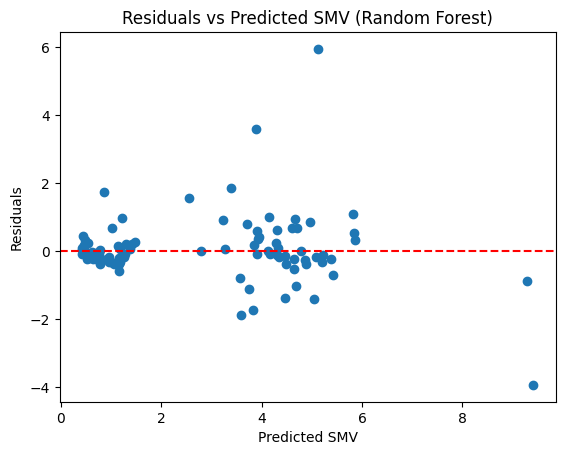

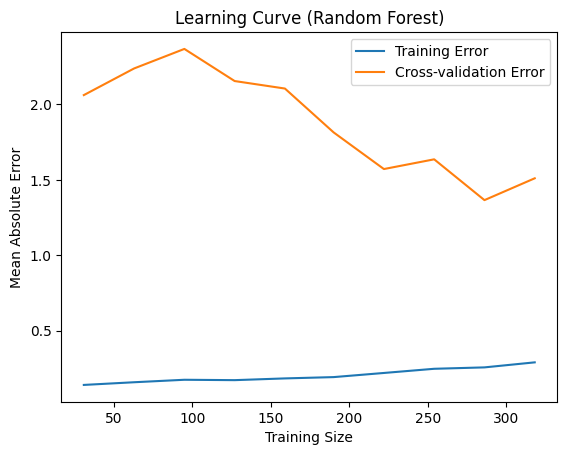

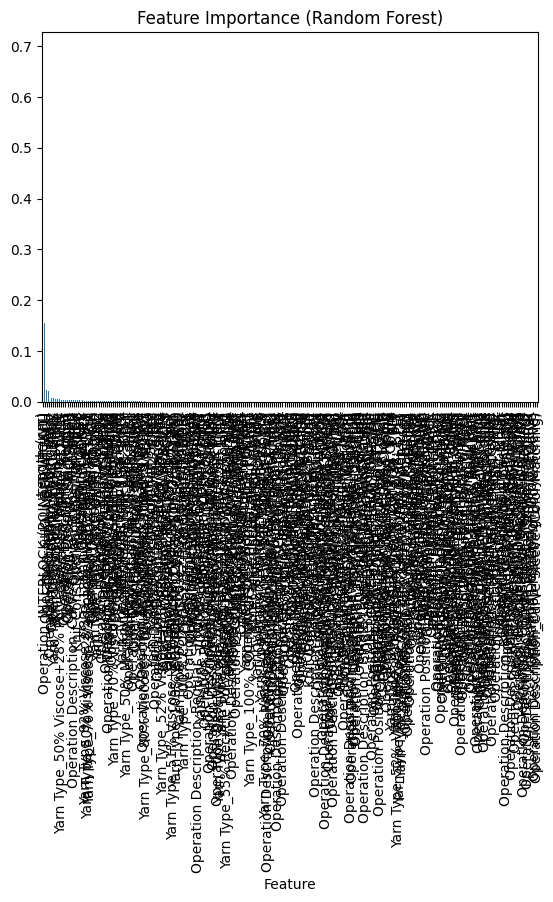

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install necessary packages
!pip install pandas scikit-learn openpyxl

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
from google.colab import files

# Load the dataset
data = pd.read_excel('/content/SMV_12GG.xlsx')

# Handle non-numeric entries and missing values
data.replace('-', pd.NA, inplace=True)
data.fillna(0, inplace=True)

# One-hot encoding categorical variables
data_encoded = pd.get_dummies(data, columns=['Operation', 'Operation Position', 'Yarn Type',
                                             'Operation Description', 'Knit Construction'])

# Prepare features (X) and target (y)
X = data_encoded.drop('SMV', axis=1)
y = data_encoded['SMV']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest Model - Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_rf = best_rf_model.predict(X_test)
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Random Forest Mean Squared Error:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R-squared:", r2_score(y_test, y_pred_rf))

# Residuals and Visualization
residuals = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted SMV')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted SMV (Random Forest)')
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_rf_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=3, scoring='neg_mean_absolute_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='Training Error')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Training Size')
plt.title('Learning Curve (Random Forest)')
plt.legend()
plt.show()

# Feature Importance for Random Forest
importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
feature_importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('Feature Importance (Random Forest)')
plt.show()

# Save the RandomForest model
joblib.dump(best_rf_model, 'trained_rf_model.pkl')

# Save test results to an Excel file
X_test_with_predictions = pd.DataFrame(X_test, columns=X.columns)
X_test_with_predictions['Actual SMV'] = y_test.reset_index(drop=True)
X_test_with_predictions['Predicted SMV (RF)'] = y_pred_rf
X_test_with_predictions.to_excel('SMV_predictions_with_categories_12GG.xlsx', index=False)

# Download the Excel file
files.download('SMV_predictions_with_categories_12GG.xlsx')
